# CS6140 Final Project Proposal: Walkability Index
### Team Members: James Fan, James Florez, Dominic Cauteruccio, Sara Spasojevic


# Step 0: Notebook Prep


In [2]:
import pandas as pd
import numpy as np
from sklearn import *
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set display options
pd.set_option("display.max_rows", 40)
pd.set_option("display.max_columns", 40)

# Set global random state
random_state = 1

# Step 1: Data Preprocessing and Analysis

#### Load Data

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

data_url = "https://edg.epa.gov/EPADataCommons/public/OA/EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv"
raw_df = pd.read_csv(data_url, sep=",", header=0)
raw_df.head()



OBJECTID       GEOID10       GEOID20  STATEFP  COUNTYFP  TRACTCE  BLKGRPCE  \
0         1  4.811300e+11  4.811300e+11       48       113     7825         4   
1         2  4.811300e+11  4.811300e+11       48       113     7825         2   
2         3  4.811300e+11  4.811300e+11       48       113     7825         3   
3         4  4.811300e+11  4.811300e+11       48       113     7824         1   
4         5  4.811300e+11  4.811300e+11       48       113     7824         2   

     CSA                  CSA_Name     CBSA                        CBSA_Name  \
0  206.0  Dallas-Fort Worth, TX-OK  19100.0  Dallas-Fort Worth-Arlington, TX   
1  206.0  Dallas-Fort Worth, TX-OK  19100.0  Dallas-Fort Worth-Arlington, TX   
2  206.0  Dallas-Fort Worth, TX-OK  19100.0  Dallas-Fort Worth-Arlington, TX   
3  206.0  Dallas-Fort Worth, TX-OK  19100.0  Dallas-Fort Worth-Arlington, TX   
4  206.0  Dallas-Fort Worth, TX-OK  19100.0  Dallas-Fort Worth-Arlington, TX   

   CBSA_POP  CBSA_EMP  CBSA_WRK    Ac_Total  Ac_Water     Ac_Land     Ac_Unpr  \
0   7189384   3545715   3364458   73.595028       0.0   73.595028   73.595028   
1   7189384   3545715   3364458  119.829909       0.0  119.829909  119.214200   
2   7189384   3545715   3364458   26.367053       0.0   26.367053   26.367050   
3   7189384   3545715   3364458  119.060687       0.0  119.060687  119.060687   
4   7189384   3545715   3364458  169.927211       0.0  169.927211  148.742920   

   TotPop  CountHU  ...       D4E    D5AR    D5AE    D5BR   D5BE      D5CR  \
0    1202    460.0  ...  0.003602  433601  303660  135362  53504  0.000398   
1     710    409.0  ...  0.006099  386504  272135  236885  90089  0.000355   
2     737    365.0  ...  0.004071  404573  288925  230587  82815  0.000371   
3     904    384.0  ...  0.007378  423099  298058  168433  79657  0.000388   
4     948    343.0  ...  0.007036  335700  238166  120826  48682  0.000308   

      D5CRI      D5CE     D5CEI      D5DR     D5DRI      D5DE     D5DEI  \
0  0.785893  0.000358  0.841299  0.000525  0.184697  0.000476  0.137707   
1  0.700531  0.000321  0.753958  0.000919  0.323221  0.000801  0.231868   
2  0.733281  0.000340  0.800475  0.000894  0.314628  0.000736  0.213146   
3  0.766859  0.000351  0.825778  0.000653  0.229821  0.000708  0.205018   
4  0.608450  0.000281  0.659846  0.000469  0.164863  0.000433  0.125296   

   D2A_Ranked  D2B_Ranked  D3B_Ranked  D4A_Ranked  NatWalkInd  Shape_Length  \
0           6          14          15          17   14.000000   3110.360820   
1           3          10          12          14   10.833333   3519.469110   
2           1           1           7          17    8.333333   1697.091802   
3          16          10          17          17   15.666667   2922.609204   
4           4           7          11          14   10.166667   3731.971773   

    Shape_Area  
0  297836.0831  
1  484945.1466  
2  106705.9281  
3  481828.4303  
4  687684.7752  

[5 rows x 117 columns]

After examining the description of each feature in the dataset's pdf, we have decided that we want to keep the following features. The goal of the project is to use the environmental and socioeconomic factors to predict the walkability score, and explore how those would affect it. In accordance with that, we have decided not to use the features already used to come up with the existing walkability score formula.

A lot of features were followed by the percentage representation of that feature in the area, which after some exploration, has shown to be the better approach (ie. auto own feature).

In [5]:
columns = ['Ac_Total', 'Ac_Water', 'Ac_Land', 'Ac_Unpr', 'TotPop', 'CountHU', 'HH', 'P_WrkAge', 'Pct_AO0',\
           'Pct_AO1', 'Pct_AO2p', 'Workers', 'R_LowWageWk', 'R_MedWageWk', \
           'R_HiWageWk', 'TotEmp', 'E5_Ret', 'E5_Off', 'E5_Ind', 'E5_Svc', 'E5_Ent', \
           'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk', \
           'D1A', 'D1B', 'D1C', 'D1D', 'D2C_TRPMX2', 'D2R_WRKEMP', 'D5AR', \
           'D5AE', 'D5BR', 'D5BE', 'NatWalkInd',]

df = raw_df[columns]
df.shape

(220740, 35)

#### Describe Data

In [6]:
# get column types
df.dtypes

Ac_Total       float64
Ac_Water       float64
Ac_Land        float64
Ac_Unpr        float64
TotPop           int64
CountHU        float64
HH             float64
P_WrkAge       float64
Pct_AO0        float64
Pct_AO1        float64
Pct_AO2p       float64
Workers          int64
R_LowWageWk      int64
R_MedWageWk      int64
R_HiWageWk       int64
TotEmp           int64
E5_Ret           int64
E5_Off           int64
E5_Ind           int64
E5_Svc           int64
E5_Ent           int64
E_LowWageWk      int64
E_MedWageWk      int64
E_HiWageWk       int64
D1A            float64
D1B            float64
D1C            float64
D1D            float64
D2C_TRPMX2     float64
D2R_WRKEMP     float64
D5AR             int64
D5AE             int64
D5BR             int64
D5BE             int64
NatWalkInd     float64
dtype: object

In [7]:
# describe numeric variables
df.describe()

Ac_Total      Ac_Water       Ac_Land       Ac_Unpr         TotPop  \
count  2.207400e+05  2.207400e+05  2.207400e+05  2.207400e+05  220740.000000   
mean   1.103567e+04  7.807248e+02  1.025494e+04  6.831866e+03    1479.863804   
std    1.588982e+05  2.683978e+04  1.488759e+05  4.367872e+04     987.862242   
min    1.096136e+00  0.000000e+00  0.000000e+00  0.000000e+00       0.000000   
25%    1.231824e+02  0.000000e+00  1.200676e+02  1.143877e+02     889.000000   
50%    3.394946e+02  0.000000e+00  3.229443e+02  3.044386e+02    1265.000000   
75%    2.325991e+03  1.973606e+01  2.141221e+03  1.950541e+03    1816.000000   
max    4.055649e+07  5.455459e+06  3.914039e+07  5.074313e+06   55407.000000   

             CountHU             HH      P_WrkAge        Pct_AO0  \
count  220465.000000  220465.000000  220740.00000  220740.000000   
mean      626.014628     548.785989       0.59474       0.092874   
std       383.714541     339.039272       0.10610       0.136020   
min         0.000000       0.000000       0.00000       0.000000   
25%       392.000000     341.000000       0.54400       0.010381   
50%       544.000000     476.000000       0.59500       0.044010   
75%       764.000000     673.000000       0.64800       0.115529   
max     26436.000000   21337.000000       1.00000       1.000000   

             Pct_AO1       Pct_AO2p        Workers    R_LowWageWk  \
count  220740.000000  220740.000000  220740.000000  220740.000000   
mean        0.328227       0.569939     637.816753     146.015815   
std         0.151983       0.219775     420.866297      90.312972   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.217391       0.432056     384.000000      91.000000   
50%         0.319574       0.603448     550.000000     128.000000   
75%         0.429613       0.737535     792.000000     181.000000   
max         1.000000       1.000000   19255.000000    3639.000000   

         R_MedWageWk     R_HiWageWk         TotEmp         E5_Ret  \
count  220740.000000  220740.000000  220740.000000  220740.000000   
mean      210.235820     281.565117     639.106487      71.185426   
std       135.076957     235.370220    2021.360339     227.948218   
min         0.000000       0.000000       0.000000       0.000000   
25%       127.000000     136.000000      69.000000       0.000000   
50%       183.000000     226.000000     200.000000      11.000000   
75%       263.000000     362.000000     548.000000      51.000000   
max      5014.000000   10683.000000  266101.000000   30444.000000   

              E5_Off         E5_Ind         E5_Svc         E5_Ent  \
count  220740.000000  220740.000000  220740.000000  220740.000000   
mean       87.631625     151.342099     256.042117      72.905219   
std       683.346046     638.944327     992.979149     358.621166   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       5.000000      17.000000       0.000000   
50%         7.000000      24.000000      63.000000      11.000000   
75%        34.000000      86.000000     195.000000      60.000000   
max    110844.000000   47840.000000  137775.000000   92976.000000   

         E_LowWageWk    E_MedWageWk     E_HiWageWk            D1A  \
count  220740.000000  220740.000000  220740.000000  220469.000000   
mean      146.436255     211.019806     281.650426       4.530262   
std       357.650538     550.314594    1273.883797      13.881912   
min         0.000000       0.000000       0.000000       0.000000   
25%        19.000000      25.000000      17.000000       0.300543   
50%        54.000000      72.000000      59.000000       1.845611   
75%       145.000000     198.000000     181.000000       4.163989   
max     38083.000000   49946.000000  204309.000000    1481.257220   

                 D1B            D1C            D1D     D2C_TRPMX2  \
count  220740.000000  220740.000000  220740.000000  220740.000000   
mean       10.428739       3.773612       8.298313 

In [8]:
# show null values
print(df.isnull().sum().sort_values(ascending=False))

CountHU        275
HH             275
D1A            271
Ac_Total         0
D1D              0
E_LowWageWk      0
E_MedWageWk      0
E_HiWageWk       0
D1B              0
D1C              0
D2C_TRPMX2       0
E5_Svc           0
D2R_WRKEMP       0
D5AR             0
D5AE             0
D5BR             0
D5BE             0
E5_Ent           0
E5_Off           0
E5_Ind           0
Ac_Water         0
E5_Ret           0
TotEmp           0
R_HiWageWk       0
R_MedWageWk      0
R_LowWageWk      0
Workers          0
Pct_AO2p         0
Pct_AO1          0
Pct_AO0          0
P_WrkAge         0
TotPop           0
Ac_Unpr          0
Ac_Land          0
NatWalkInd       0
dtype: int64


In [9]:
# Drop household NaN samples
df = df.dropna(subset=['CountHU'], axis=0)
df = df.dropna(subset=['HH'], axis=0)

# fill the leftover null variables with median
df = df.fillna(df.median())

df.shape


(220465, 35)

# Exploratory Data Analysis

## Univariate Analysis through Histograms

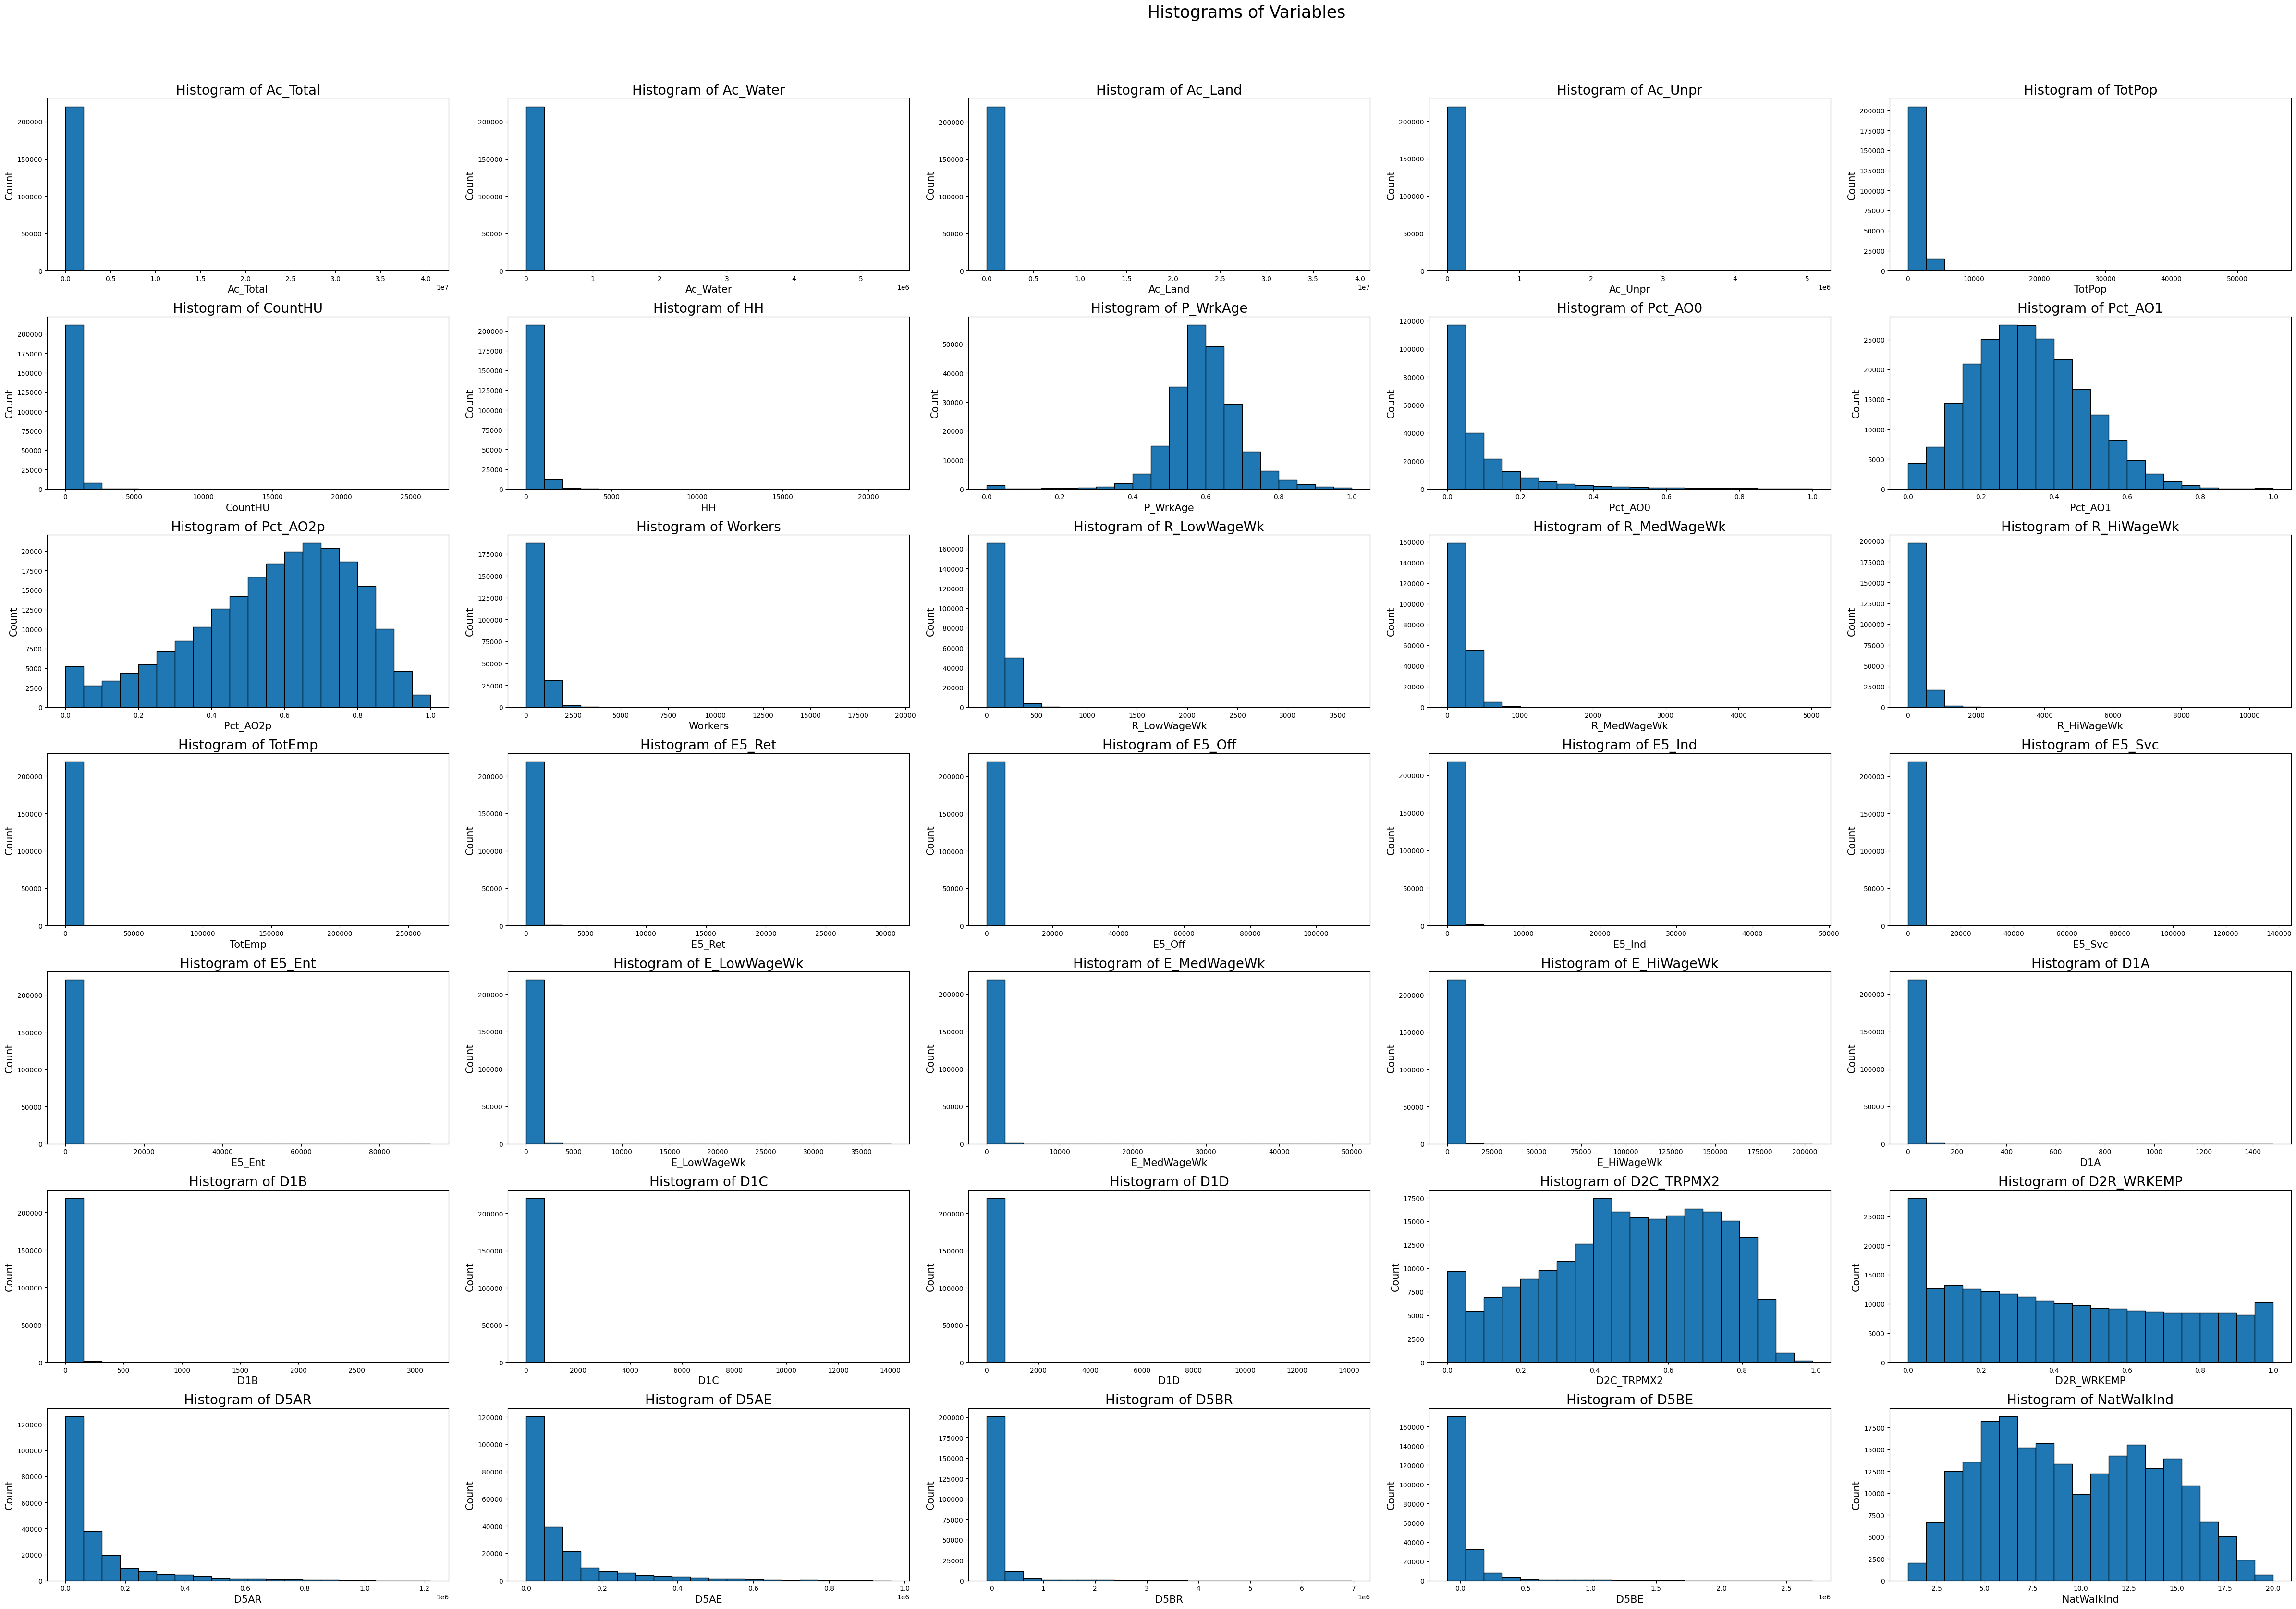

In [10]:
plt.figure(figsize=(40, 30))
for i, column in enumerate(df.columns):
    plt.subplot(8, 5, i + 1)
    df[column].hist(bins=20, edgecolor='black', linewidth=1.0, grid=False)
    plt.title(f'Histogram of {column}', fontsize=20)
    plt.xlabel(column, fontsize=15)
    plt.ylabel('Count', fontsize=15)

plt.tight_layout(rect=(0, 0, 1.2, 1.2))
plt.suptitle('Histograms of Variables', x=0.65, y=1.25, fontsize=25)
plt.show()


## Covariate Analysis

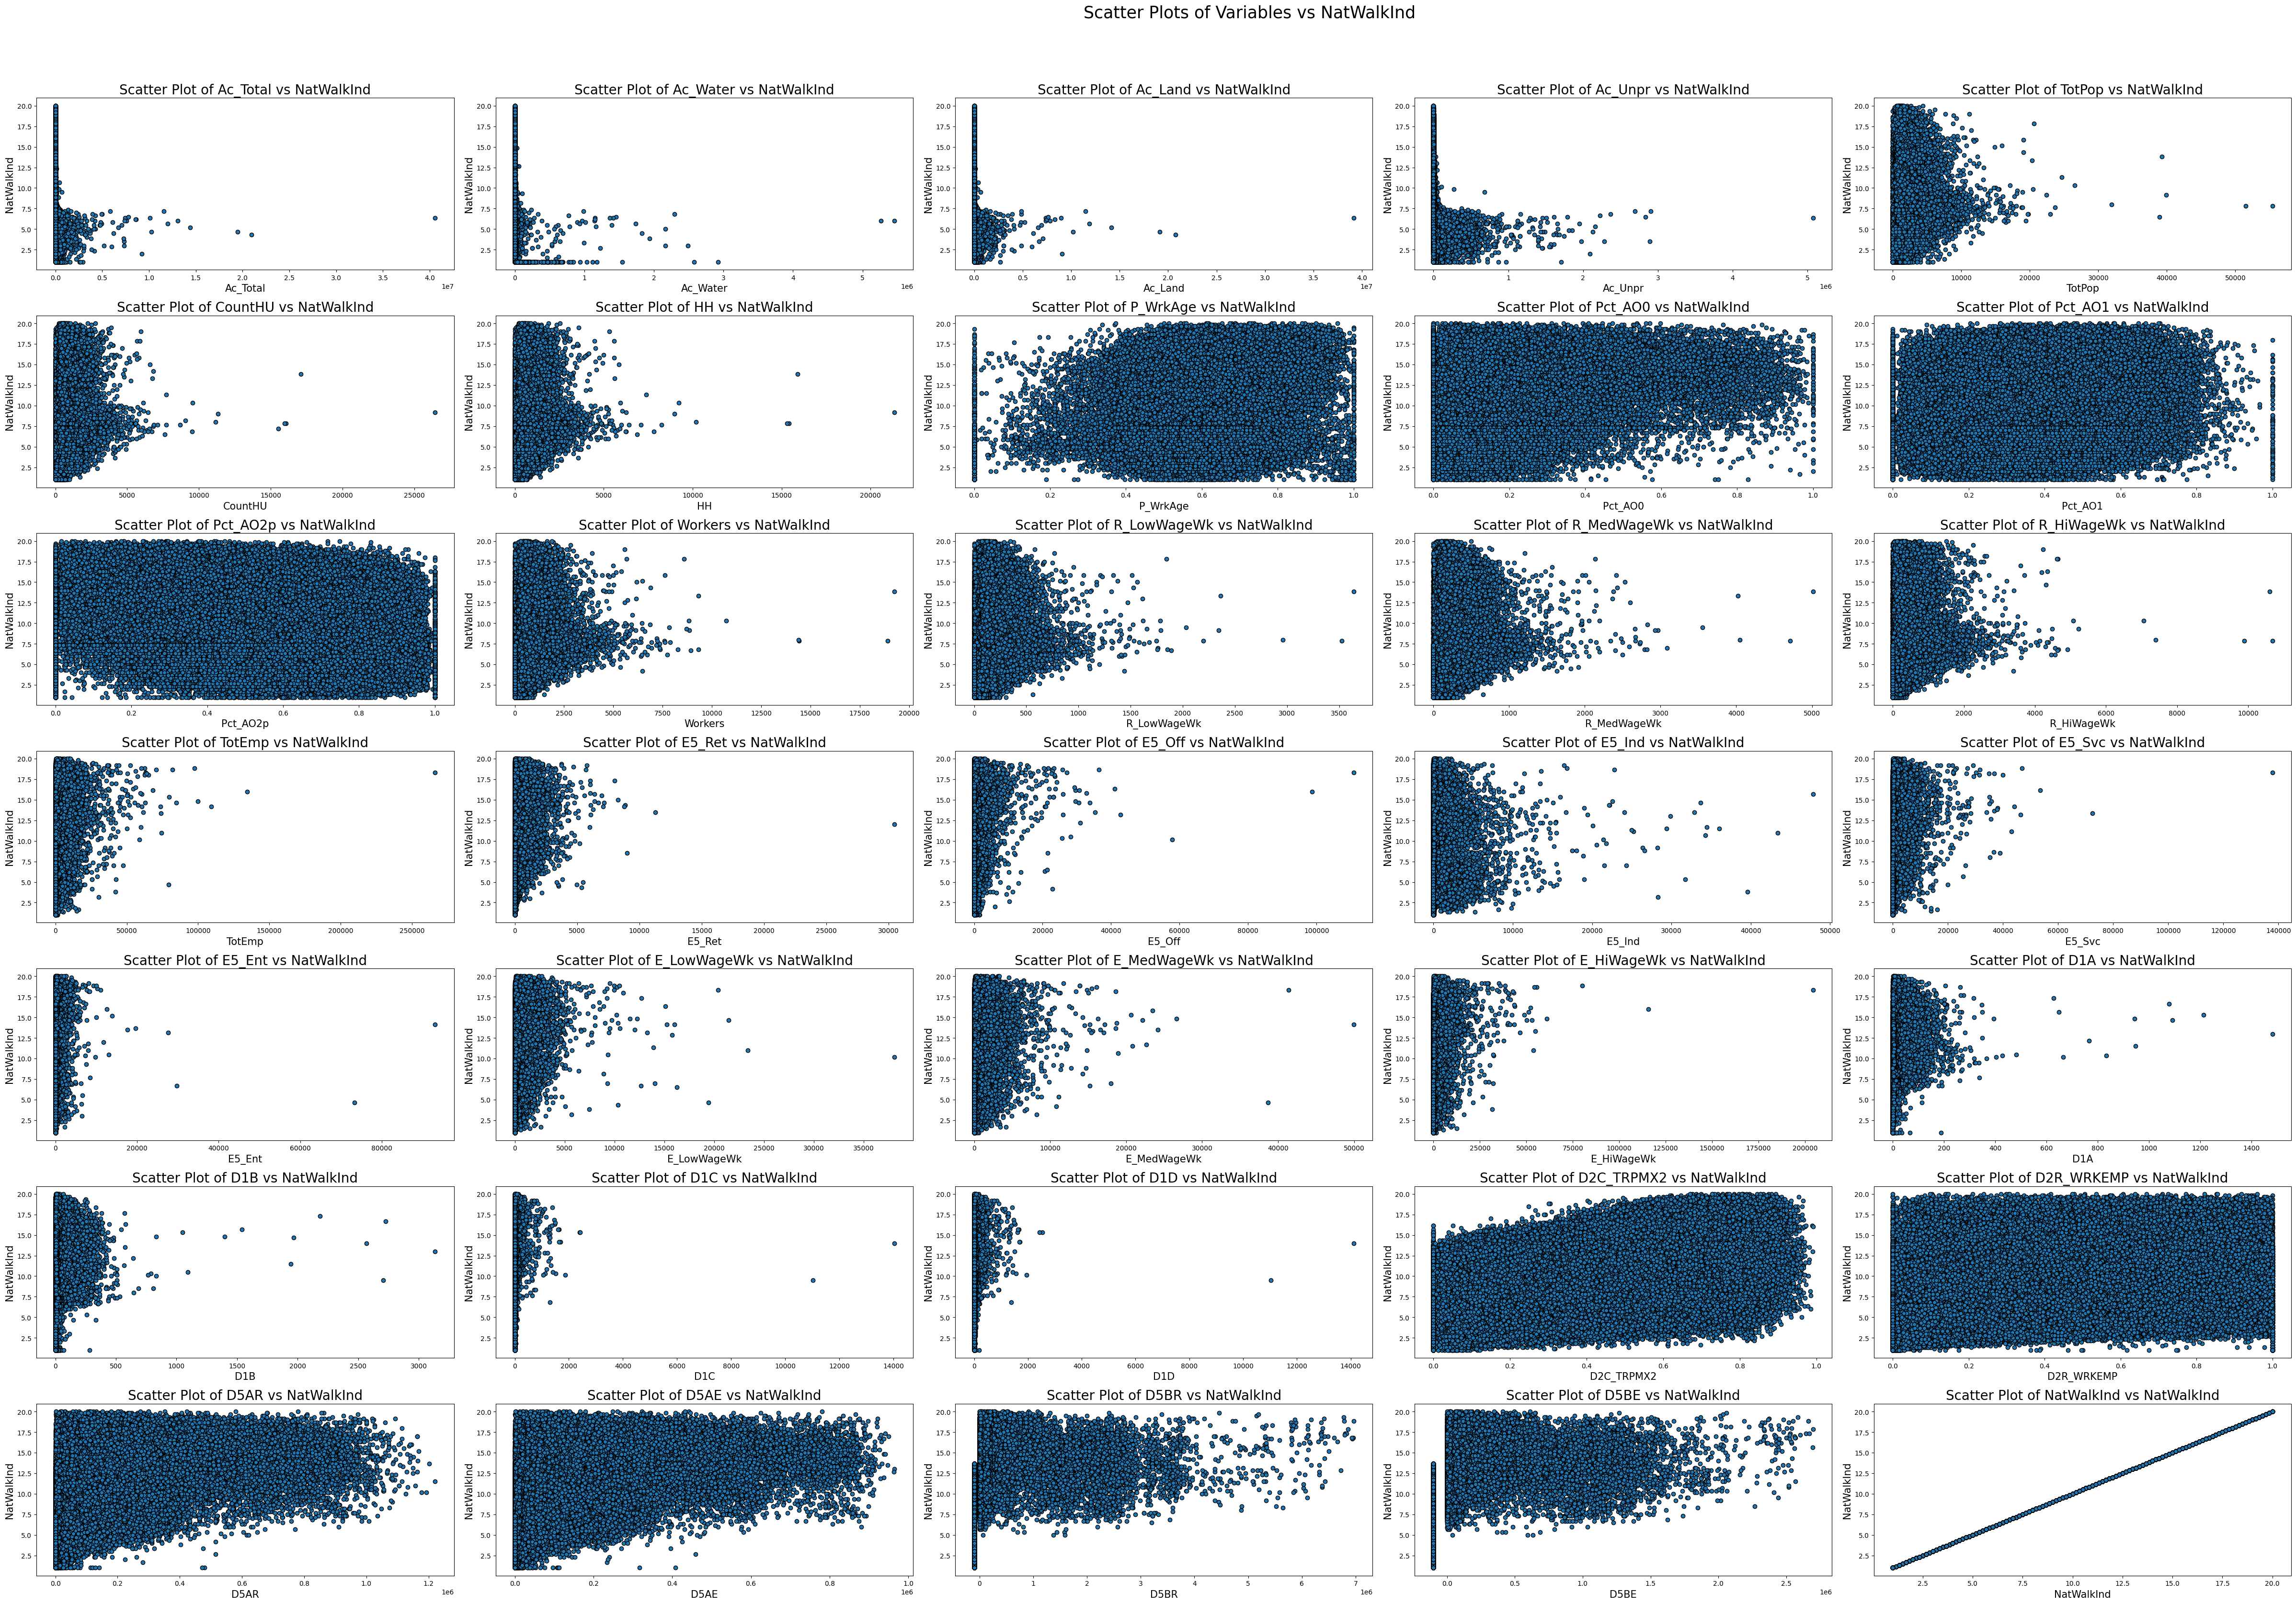

In [11]:
plt.figure(figsize=(40, 30))
for i, column in enumerate(columns):
    plt.subplot(8, 5, i + 1)
    sns.scatterplot(data=df, x=column, y='NatWalkInd', edgecolor='black', linewidth=1.0)
    plt.title(f'Scatter Plot of {column} vs NatWalkInd', fontsize=20)
    plt.xlabel(column, fontsize=15)
    plt.ylabel('NatWalkInd', fontsize=15)

plt.tight_layout(rect=(0, 0, 1.2, 1.2))
plt.suptitle('Scatter Plots of Variables vs NatWalkInd', x=0.65, y=1.25, fontsize=25)
plt.show()

## Correlation Matrix

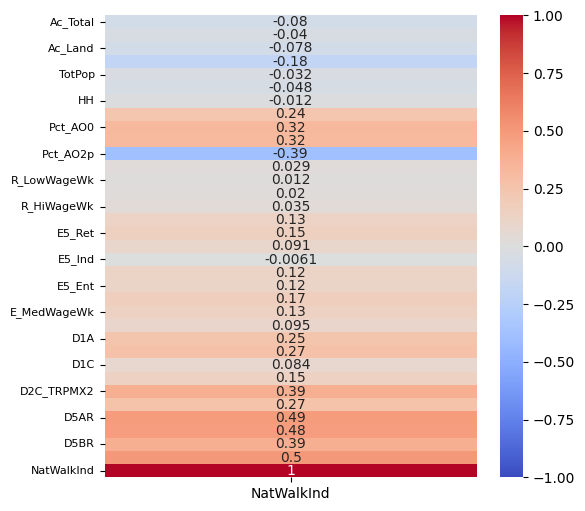

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(6,6))
sns.heatmap(correlation_matrix[['NatWalkInd']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.yticks(fontsize=8)
plt.show()

## Head count per acre

We decided to create a feature that will show the head count per acre.

In [ ]:
df[["TotPop", "Ac_Total", "NatWalkInd"]].corr()

TotPop  Ac_Total  NatWalkInd
TotPop      1.000000 -0.020725   -0.031859
Ac_Total   -0.020725  1.000000   -0.080179
NatWalkInd -0.031859 -0.080179    1.000000

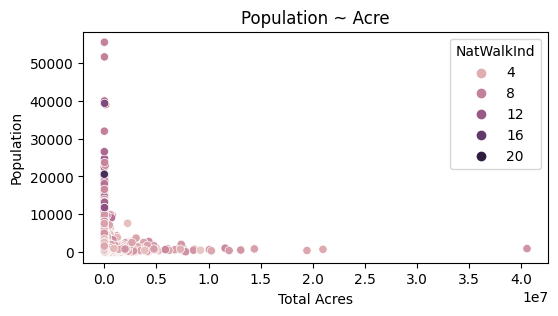

In [ ]:
df['Pop_Acre'] = df['TotPop'] / df['Ac_Total']

plt.figure(figsize=(6, 3))
sns.scatterplot(df, x="Ac_Total", y="TotPop", hue="NatWalkInd")
plt.title('Population ~ Acre')
plt.xlabel('Total Acres')
plt.ylabel('Population')
plt.show()

After the feature was created, see below impact in the correlation map. It performs much higher than the TotPop.

In [ ]:
df[["Pop_Acre", "NatWalkInd"]].corr()

Pop_Acre  NatWalkInd
Pop_Acre    1.000000    0.307833
NatWalkInd  0.307833    1.000000

## Auto

Looking at the correlation heatmap and the way auto affects the walkability score, we decided to consolidate them to 1 or none, and 2 or more cars, to see how it would affect the score.

In [ ]:
df[["Pct_AO0", "Pct_AO1", "Pct_AO2p", "NatWalkInd"]].corr()

Pct_AO0   Pct_AO1  Pct_AO2p  NatWalkInd
Pct_AO0     1.000000  0.128376 -0.686125    0.322431
Pct_AO1     0.128376  1.000000 -0.695753    0.319058
Pct_AO2p   -0.686125 -0.695753  1.000000   -0.386020
NatWalkInd  0.322431  0.319058 -0.386020    1.000000

In [ ]:
df['Pct_A_OneNone'] = df['Pct_AO0'] + df['Pct_AO1']

df.drop(['Pct_AO0', 'Pct_AO1'], axis=1, inplace=True)

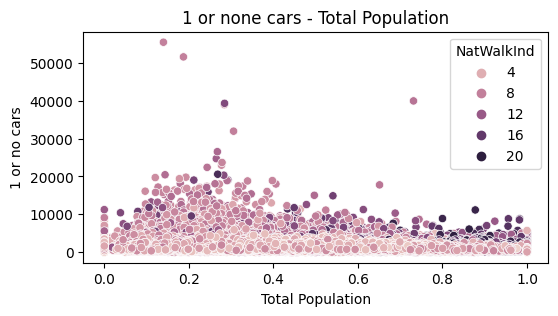

In [ ]:
plt.figure(figsize=(6, 3))
sns.scatterplot(df, x="Pct_A_OneNone", y="TotPop", hue="NatWalkInd")
plt.title('1 or none cars - Total Population')
plt.xlabel('Total Population')
plt.ylabel('1 or no cars')
plt.show()

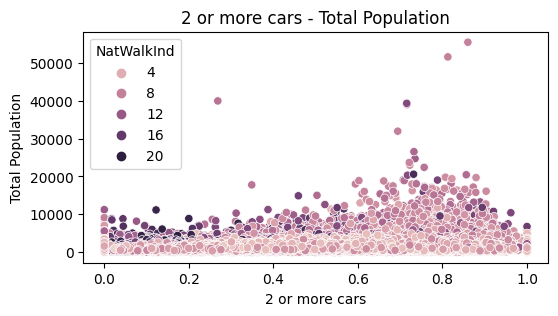

In [ ]:
plt.figure(figsize=(6, 3))
sns.scatterplot(df, x="Pct_AO2p", y="TotPop", hue="NatWalkInd")
plt.title('2 or more cars - Total Population')
plt.xlabel('2 or more cars')
plt.ylabel('Total Population')
plt.show()

Let's look at the correlation scores after this feature was created.

In [ ]:
df[["Pct_A_OneNone", "Pct_AO2p", "NatWalkInd"]].corr()

Pct_A_OneNone  Pct_AO2p  NatWalkInd
Pct_A_OneNone       1.000000  -0.91918    0.426415
Pct_AO2p           -0.919180   1.00000   -0.386020
NatWalkInd          0.426415  -0.38602    1.000000

## Household

Observe that we have features CountHU and HH, which are total number of households in that sector, and number of households occupied, respectively.
We chose to create one variable "Occupied" that will show the percentage of the occupied households.

In [ ]:
df['Occupied'] = df.apply(lambda row: (row['HH'] / row['CountHU']) * 100 if row['CountHU'] != 0 else 100, axis=1)
df.drop(["CountHU", "HH"], axis=1, inplace=True)

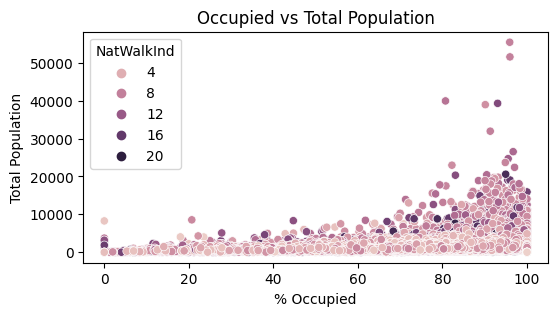

In [ ]:
plt.figure(figsize=(6, 3))
sns.scatterplot(df, x="Occupied", y="TotPop", hue="NatWalkInd")
plt.title('Occupied vs Total Population')
plt.xlabel('% Occupied')
plt.ylabel('Total Population')
plt.show()

## Wage - residents

In [ ]:
df['Pct_HighWage_Reside'] = df.apply(lambda row: ((row['R_HiWageWk'])/ row['Workers']) * 100 if row['Workers'] != 0 else 0, axis=1)
df.drop(['R_LowWageWk', 'R_MedWageWk', 'R_HiWageWk', 'Workers'], axis=1, inplace=True)

Let's see if there's a relationship between walkability and percentage of population that earns a high wage in areas that are labeled unwalkable (> 15).

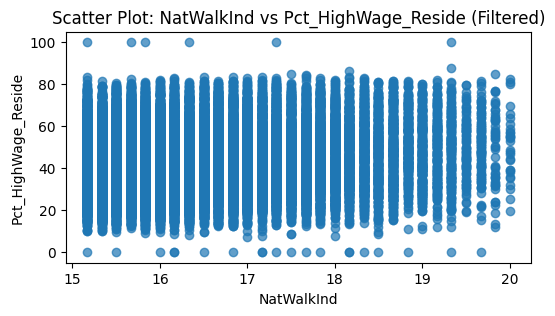

In [ ]:
unwalkable = df[df['NatWalkInd'] > 15]

plt.figure(figsize=(6, 3))
plt.scatter(unwalkable['NatWalkInd'], unwalkable['Pct_HighWage_Reside'], alpha=0.7)
plt.title('Scatter Plot: NatWalkInd vs Pct_HighWage_Reside (Filtered)')
plt.xlabel('NatWalkInd')
plt.ylabel('Pct_HighWage_Reside')
plt.show()

From the graph we cannot observe any particular relationship, and seems like with only very high unwalkable scores (19, 20) increase the percentage of population with higher income.

See the correlation with walkability index below:

In [ ]:
df[["Pct_HighWage_Reside", "NatWalkInd"]].corr()

Pct_HighWage_Reside  NatWalkInd
Pct_HighWage_Reside             1.000000    0.112913
NatWalkInd                      0.112913    1.000000

## E5

Taking a look at types of jobs in the area, and correlation map, we've decided to drop the Industrial, as they don't have a high predicting contribution. The highest seems to be retail, service and entertainment.

In [ ]:
df['Pct_Retail'] = df.apply(lambda row: ((row['E5_Ret'])/ row['TotEmp']) * 100 if row['TotEmp'] != 0 else 0, axis=1)

df['Pct_Service'] = df.apply(lambda row: ((row['E5_Svc'])/ row['TotEmp']) * 100 if row['TotEmp'] != 0 else 0, axis=1)

df['Pct_Ent'] = df.apply(lambda row: ((row['E5_Ent'])/ row['TotEmp']) * 100 if row['TotEmp'] != 0 else 0, axis=1)

df.drop(['E5_Ret', 'E5_Off', 'E5_Ind','E5_Svc', 'E5_Ent'], axis=1, inplace=True)

Let's take a look at the correlation matrix after all the new features were made.

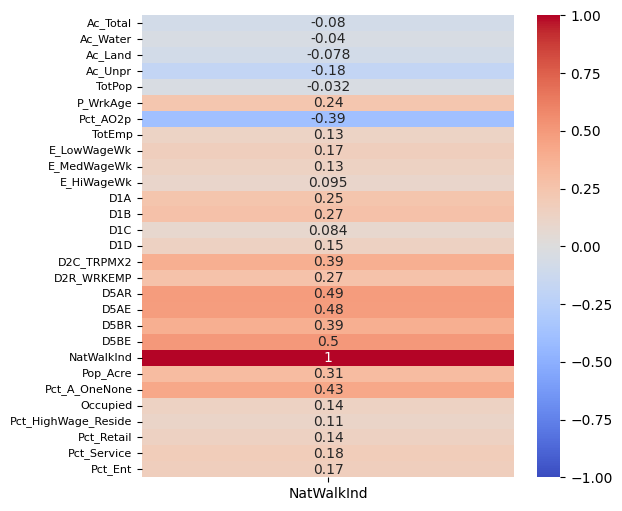

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(6,6))
sns.heatmap(correlation_matrix[['NatWalkInd']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.yticks(fontsize=8)
plt.show()

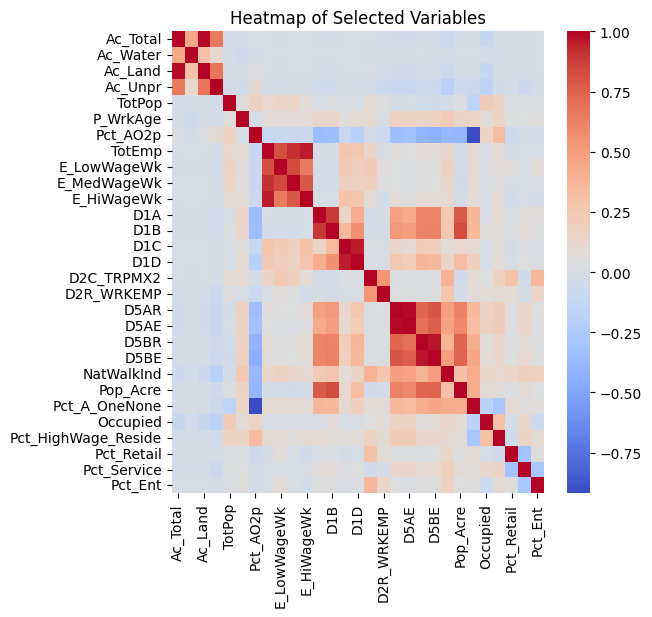

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Selected Variables')
plt.show()

### Some more insight

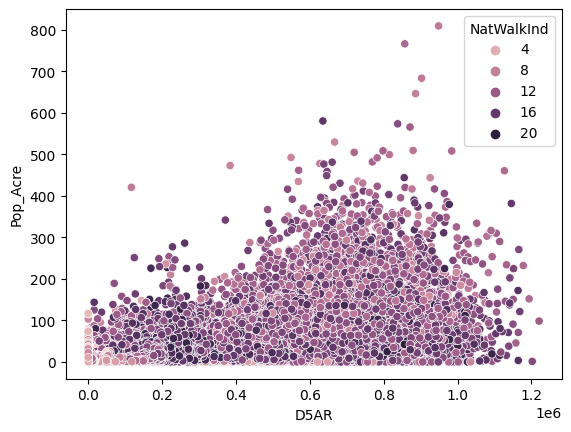

In [ ]:
# Jobs within 45 minutes auto travel time vs Population per Acre
sns.scatterplot(df, x="D5AR", y="Pop_Acre", hue="NatWalkInd")
plt.show()

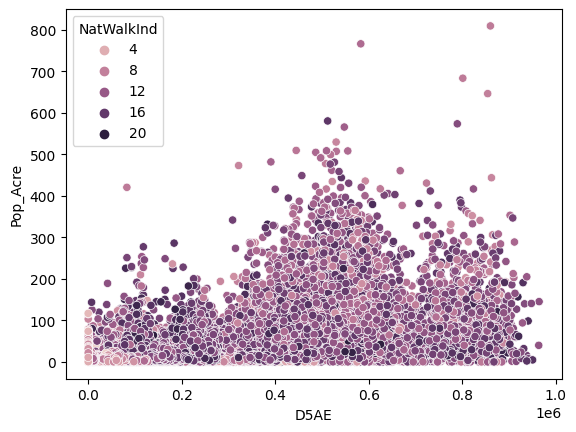

In [ ]:
# Working age population within 45 minutes auto travel time vs Population per Acre
sns.scatterplot(df, x="D5AE", y="Pop_Acre", hue="NatWalkInd")
plt.show()

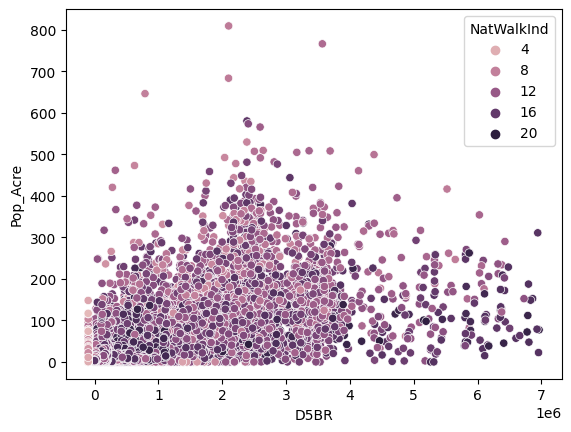

In [ ]:
# Jobs within 45 minutes train travel commute vs Population per Acre
sns.scatterplot(df, x="D5BR", y="Pop_Acre", hue="NatWalkInd")
plt.show()

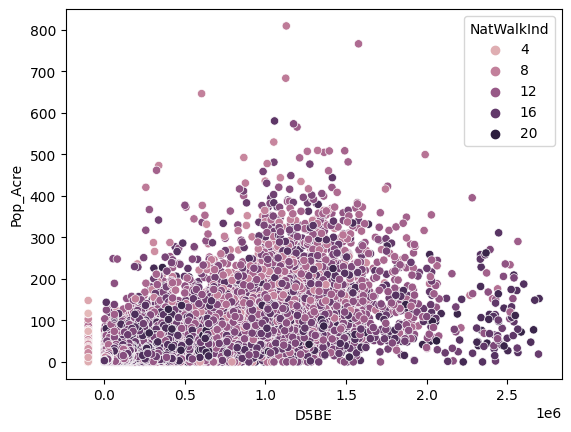

In [ ]:
# Working age population within 45 minutes transit commute vs Population per Acre
sns.scatterplot(df, x="D5BE", y="Pop_Acre", hue="NatWalkInd")
plt.show()

# Step 2: Model Creation

#### Split and Standardize the Dataset

In [12]:
# Function that splits dataset - K-fold
def create_splits(X, y):
    X_train_splits = []
    X_test_splits = []
    y_train_splits = []
    y_test_splits = []

    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=random_state)

    for train_index, test_index in kf.split(X):
        # set new train/test groups
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # append to lists for use later
        X_train_splits.append(X_train)
        X_test_splits.append(X_test)
        y_train_splits.append(y_train)
        y_test_splits.append(y_test)

    return X_train_splits, X_test_splits, y_train_splits, y_test_splits

In [13]:
# Split data into X and Y
y = df["NatWalkInd"]
X = df.drop("NatWalkInd", axis=1)

#### Define Hyperparameters and Initialize Models

In [14]:
# Linear Regression
linear = linear_model.LinearRegression()

# Ridge Regression
ridge_alpha = 1.1 # Regularization param, default is 1.0 for full penalty
ridge = linear_model.Ridge(alpha=ridge_alpha)

# Random Forest
rf_estimators = 10
rf_max_depth = None  # You can adjust the max depth for regularization
rf_min_samples_leaf = 10
rf_max_features = 10
random_forest = ensemble.RandomForestRegressor(n_estimators=rf_estimators, max_depth=None, random_state=random_state,
                                               min_samples_leaf = rf_min_samples_leaf, max_features = rf_max_features)


# Support Vector Machine (SVM)
svm_kernel = "rbf"
svm_c = 20 # Tolerance and margin/slack
svm_epsilon = 1.0  # Regularization parameter for SVM, default 0.1 but can be changed
svm_max_iter = 1000 # Iteration for convergence
svm_model = svm.SVR(kernel=svm_kernel, C=svm_c, epsilon=svm_epsilon, max_iter=svm_max_iter)

# Multi-Layer Perceptron (MLP)
mlp_num_layers = 1
mlp_num_neurons = 20
mlp_alpha = 0.1 # Regularization param
mlp_learning_rate_init = 0.001
mlp_max_iter = 300
mlp = neural_network.MLPRegressor(
    hidden_layer_sizes=(mlp_num_neurons, mlp_num_layers),
    alpha=mlp_alpha,
    learning_rate_init=mlp_learning_rate_init,
    max_iter=mlp_max_iter,
    random_state=random_state)

## Step 3: Model Training and Evaluation

In [15]:
# Define a function to train and evaluate a regression model

def model_train_and_eval_single(model, X_train, X_test, y_train, y_test, columns, model_name, visual, reg_param):
  # Given a regression model and data, this trains the model, plots the coefficients, and evaluates the performance.

  # Train the model with training data
    if reg_param:
        if model_name == "Ridge":
            model.set_params(alpha=reg_param)
        elif model_name == "RandomForestRegressor":
            model.set_params(max_depth=reg_param)
            # Adjust regularization parameters for RandomForest if needed
        elif model_name == "SVM":
            model.set_params(C=reg_param)
        elif model_name == "MLPRegressor":
            model.set_params(alpha=reg_param)

    # Train the model with training data
    model.fit(X_train, y_train)

    # Make predicitions on test data
    y_pred = model.predict(X_test)

    # Plot the weights of the model
    if (model_name in ["Linear", "Ridge"]) and visual:
      plt.plot(columns, model.coef_)
      plt.title(f"Coefficients of {model_name} Regression Model")
      plt.xticks(rotation=90)
      plt.grid()
      plt.show()

    # Evaluate performance of the model
    mse = metrics.mean_squared_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    return mse, r2


# Initialize variable to hold MSE and R^2 results
mse_list = []
r2_list = []

In [16]:
def model_train_and_eval(model, X, y, k_fold=True, standardization=True, model_name=None, visual = False, reg_param=None, pca=False):
    columns = X.columns
    if k_fold:
        kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
        mse_list = []
        r2_list = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            if standardization:
                scaler = preprocessing.StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)

            # perform pca
            if pca:
              pca = decomposition.PCA(6)  # Specify the number of components
              X_train = pca.fit_transform(X_train)
              X_test = pca.transform(X_test)

            mse, r2 = model_train_and_eval_single(model, X_train, X_test, y_train, y_test, columns, model_name, visual, reg_param)
            mse_list.append(mse)
            r2_list.append(r2)

        return mse_list, r2_list

    else:
        if standardization:
            scaler = preprocessing.StandardScaler()
            X = scaler.fit_transform(X)

        # perform pca
        if pca:
          pca = decomposition.PCA(6)  # Specify the number of components
          X_train = pca.fit_transform(X_train)
          X_test = pca.transform(X_test)

        # Use an 80-20 train-test split
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

        return model_train_and_eval_single(model, X_train, X_test, y_train, y_test, columns, model_name, visual, reg_param)

#### Linear Regression

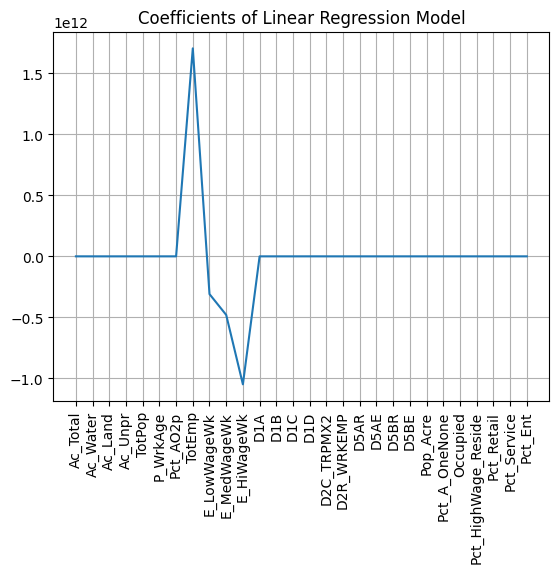

Mean Squared Error: 7.261632126151973
R-squared: 0.6181548750696602


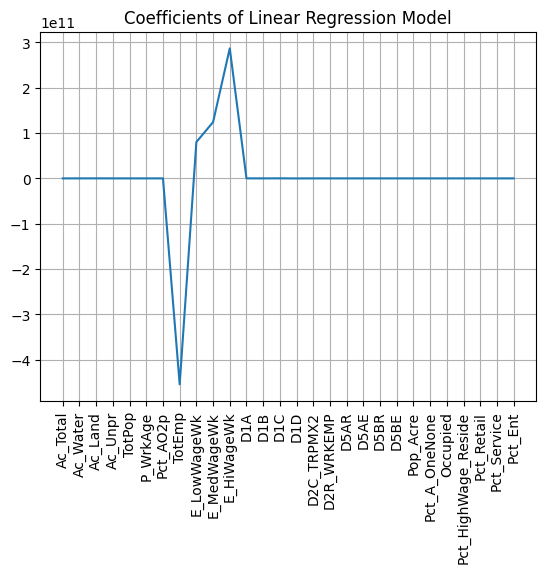

Mean Squared Error: 7.361029627970924
R-squared: 0.6168907506022241


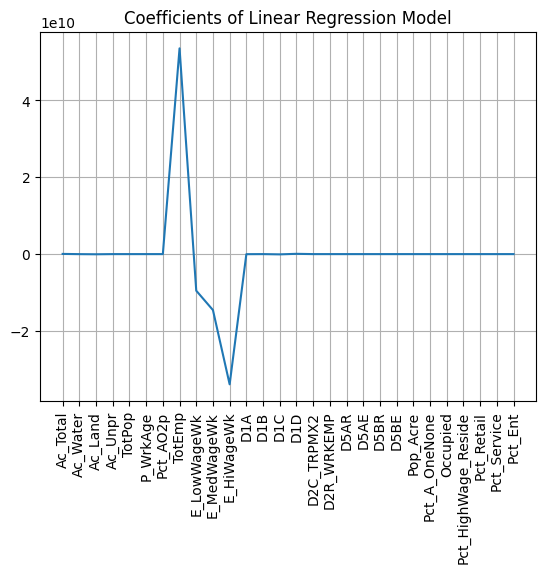

Mean Squared Error: 7.301038508817253
R-squared: 0.6131275460917383


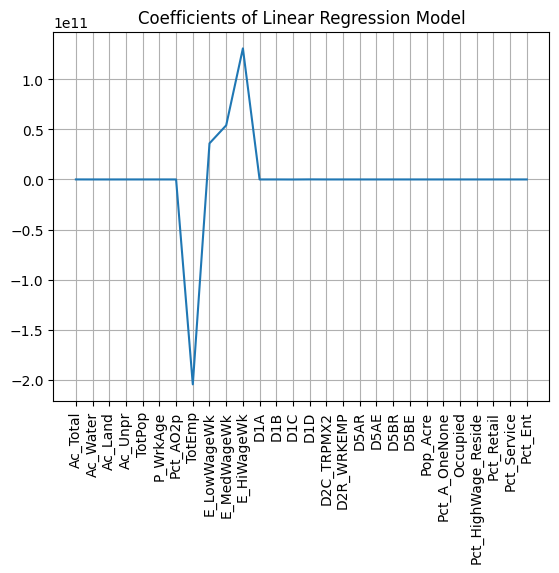

Mean Squared Error: 7.349937684565887
R-squared: 0.6180152310844942


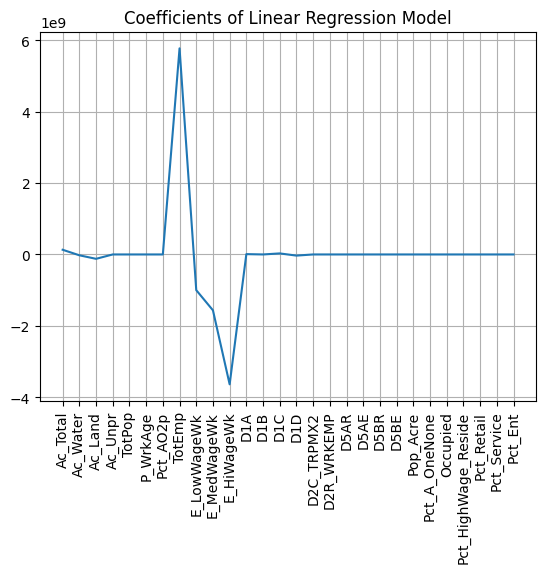

Mean Squared Error: 7.3404759727613484
R-squared: 0.6131595586088905

Mean MSE: 7.322822784053477
Mean R-squared: 0.6158695922914014


In [ ]:
linear_mse_list, linear_r2_list = model_train_and_eval(linear, X, y, model_name="Linear", visual=True, reg_param=None)

mse_list.append(np.mean(linear_mse_list))
r2_list.append(np.mean(linear_r2_list))

print(f"\nMean MSE: {np.mean(linear_mse_list)}")
print(f"Mean R-squared: {np.mean(linear_r2_list)}")

#### Ridge Regression

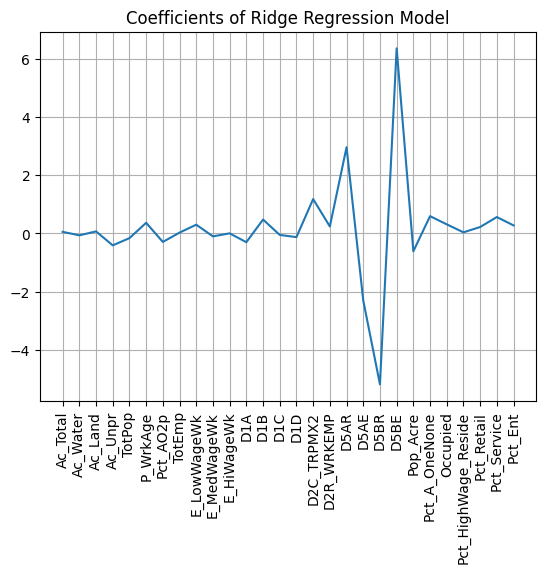

Mean Squared Error: 7.260700749321832
R-squared: 0.6182038505197909


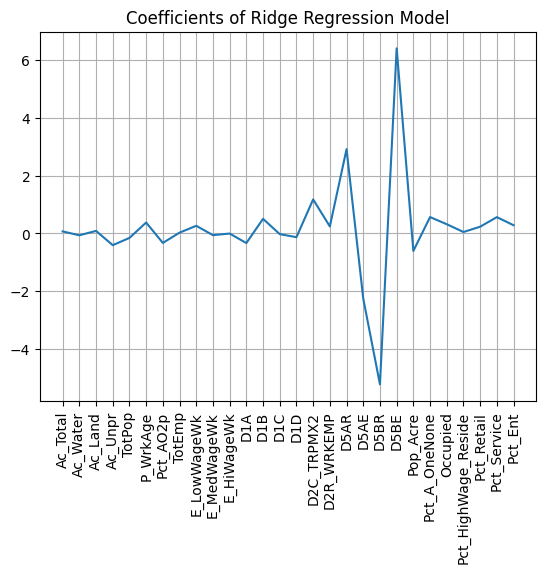

Mean Squared Error: 7.34241751314316
R-squared: 0.6178594294014882


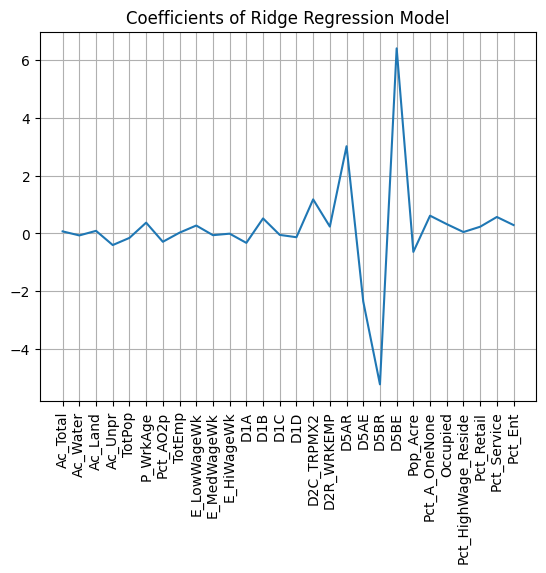

Mean Squared Error: 7.300091989327179
R-squared: 0.6131777009179804


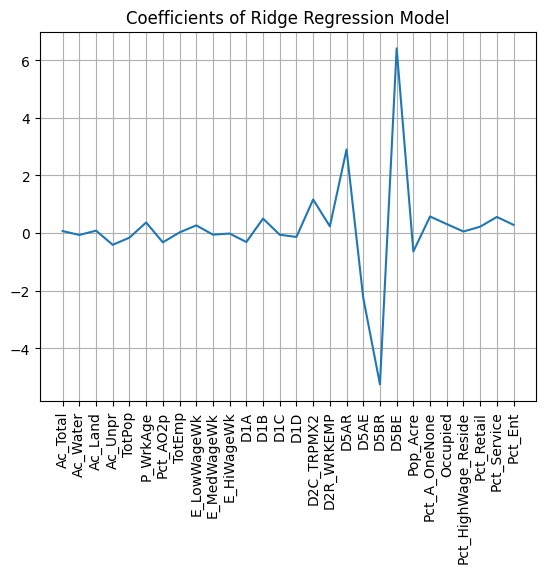

Mean Squared Error: 7.349783092186287
R-squared: 0.6180232654294007


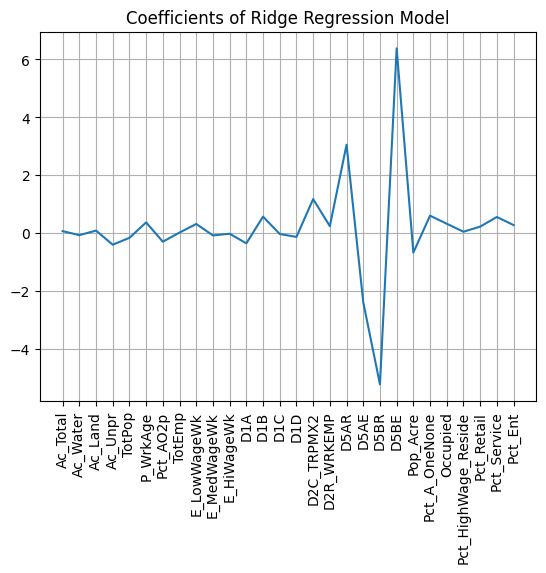

Mean Squared Error: 7.3357803466433245
R-squared: 0.6134070164150116

Mean MSE: 7.317754738124355
Mean R-squared: 0.6161342525367344


In [ ]:
ridge_mse_list, ridge_r2_list = model_train_and_eval(ridge, X, y, model_name="Ridge", visual=True, reg_param=1)

mse_list.append(np.mean(ridge_mse_list))
r2_list.append(np.mean(ridge_r2_list))

print(f"\nMean MSE: {np.mean(ridge_mse_list)}")
print(f"Mean R-squared: {np.mean(ridge_r2_list)}")

#### Random Forest

In [ ]:
rf_mse_list, rf_r2_list = model_train_and_eval(random_forest, X, y, model_name="Random Forest")

mse_list.append(np.mean(rf_mse_list))
r2_list.append(np.mean(rf_r2_list))

print(f"\nMean MSE: {np.mean(rf_mse_list)}")
print(f"Mean R-squared: {np.mean(rf_r2_list)}")

Mean Squared Error: 1.2967293694464246
R-squared: 0.9318128790504434
Mean Squared Error: 1.2844590970363183
R-squared: 0.933149547628791
Mean Squared Error: 1.2886262015059158
R-squared: 0.9317173878558495
Mean Squared Error: 1.2969831388828834
R-squared: 0.9325942850326701
Mean Squared Error: 1.305628232153706
R-squared: 0.9311938621564568

Mean MSE: 1.29448520780505
Mean R-squared: 0.9320935923448422


#### Support Vector Machine

In [ ]:
svm_mse_list, svm_r2_list = model_train_and_eval(svm_model, X, y, model_name="SVM", reg_param=svm_c)

mse_list.append(np.mean(svm_mse_list))
r2_list.append(np.mean(svm_r2_list))

print(f"\nMean MSE: {np.mean(svm_mse_list)}")
print(f"Mean R-squared: {np.mean(svm_r2_list)}")

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 5.835541489286329
R-squared: 0.6931443193069726


#### Multi-Layer Perceptron

In [ ]:
mlp_mse_list, mlp_r2_list = model_train_and_eval(mlp, X, y, model_name="MLP", reg_param=mlp_alpha)

mse_list.append(np.mean(mlp_mse_list))
r2_list.append(np.mean(mlp_r2_list))

print(f"\nMean MSE: {np.mean(mlp_mse_list)}")
print(f"Mean R-squared: {np.mean(mlp_r2_list)}")

#### Plot Performance of Different Models

In [ ]:
plt.bar(["Linear", "Ridge", "Random Forest", "SVM", "MLP"], mse_list)
plt.title("Mean Squared Error")
plt.show()

In [ ]:
plt.bar(["Linear", "Ridge", "Random Forest", "SVM", "MLP"], r2_list)
plt.title("R^2")
plt.show()

# Ablation Studies

## Linear Regression

There is not that much to take away with linear regression given that it's a pretty simple model. The ablation studies done here will show how taking away different features affect the model.


#### Baseline:
Mean MSE: 7.3227815553547

Mean R-squared: 0.6158717291344789

### Engineered features

Let's take away the engineered features to show how this will affect the score.

In [ ]:
features = df.columns.tolist()
print(features)

In [ ]:
df_no_eng = df[['Ac_Total', 'Ac_Water', 'Ac_Land', 'Ac_Unpr', 'TotPop', 'P_WrkAge', \
                'Pct_AO2p', 'TotEmp', 'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk', \
                'D1A', 'D1B', 'D1C', 'D1D', 'D2C_TRPMX2', 'D2R_WRKEMP', 'D5AR', 'D5AE', \
                'D5BR', 'D5BE', 'NatWalkInd']]

y_no_eng = df_no_eng['NatWalkInd']
X_no_eng = df_no_eng.drop("NatWalkInd", axis=1)

linear_mse_no_eng, linear_r2_no_eng = model_train_and_eval(linear, X_no_eng, y_no_eng, model_name="Linear")

print(f"\nMean MSE: {np.mean(linear_mse_no_eng)}")
print(f"Mean R-squared: {np.mean(linear_r2_no_eng)}")

As expected, you can see how taking away these features lowers the score.

### Environmental Factors

Given that our project's goal is to explore environmental and socioeconomical factors' effect on ealkability score, let's try taking away the environmental factors.

In [ ]:
df_no_env = df[['TotPop', 'P_WrkAge', 'Pct_AO2p', 'TotEmp', 'E_LowWageWk', 'E_MedWageWk', \
                'E_HiWageWk', 'D1A', 'D1B', 'D1C', 'D1D', 'D2C_TRPMX2', 'D2R_WRKEMP', \
                'D5AR', 'D5AE', 'D5BR', 'D5BE', 'NatWalkInd', 'Pop_Acre', 'Pct_A_OneNone', \
                'Occupied', 'Pct_HighWage_Reside', 'Pct_Retail', 'Pct_Service', 'Pct_Ent']]

y_no_env = df_no_env['NatWalkInd']
X_no_env = df_no_env.drop("NatWalkInd", axis=1)

linear_mse_no_env, linear_r2_no_env = model_train_and_eval(linear, X_no_env, y_no_env, model_name="Linear")

print(f"\nMean MSE: {np.mean(linear_mse_no_env)}")
print(f"Mean R-squared: {np.mean(linear_r2_no_env)}")

It is interesting to see that removing the basic features like size of land of the sector, amount of unprotected land and water, does not affect the score significantly. Some of the features we left in this ablation steps have to do with the amount of jobs/people within specific distance, and as these are not solely environmental factors, we've decided to keep them in.

### Socioeconomic factors

This is the big step as it will show the importance of these features in our model. We chose to remove everything that has to do with wages, social status, and keep only the environmental features.

In [ ]:
df_no_soc = df[['Ac_Total', 'Ac_Water', 'Ac_Land', 'Ac_Unpr', 'D5AR', 'D5AE', 'D5BR', 'D5BE', \
                 'NatWalkInd']]

y_no_soc = df_no_soc['NatWalkInd']
X_no_soc = df_no_soc.drop("NatWalkInd", axis=1)

linear_mse_no_soc, linear_r2_no_soc = model_train_and_eval(linear, X_no_soc, y_no_soc, model_name="Linear")

print(f"\nMean MSE: {np.mean(linear_mse_no_soc)}")
print(f"Mean R-squared: {np.mean(linear_r2_no_soc)}")

As expected, the score drops significantly. This shows that environmental factors do have some predicting power, however, the importance lies in the socioeconomic ones.

Following, we have decided to explore Ridge Regression to see if the regularization factor would improve our scores.

## Ridge Regression

#### Baseline:

Mean MSE: 7.31775473812438

Mean R-squared: 0.6161342525367332

One thing we can ablate here is the level of regularization. As our alpha is set to 1, I will first set it to very close to 0 - very little regularization.

In [ ]:
ridge_mse_lowr, ridge_r2_lowr = model_train_and_eval(ridge, X, y, model_name="Ridge", reg_param = 0.1)

print(f"\nMean MSE: {np.mean(ridge_mse_lowr)}")
print(f"Mean R-squared: {np.mean(ridge_r2_lowr)}")

As seen above, when regularization is dropped to 0.1, there is not much change in scores.

Let's see if the number is significantly increased:

In [ ]:
ridge_mse_hir, ridge_r2_hir = model_train_and_eval(ridge, X, y, model_name="Ridge", reg_param = 100)

print(f"\nMean MSE: {np.mean(ridge_mse_hir)}")
print(f"Mean R-squared: {np.mean(ridge_r2_hir)}")

Not even making it overly high makes the number different. If the dataset is not very noisy or if there are not many highly correlated features, our model may not be that sensitive to changes in alpha. Ridge regression is more effective when dealing with multicollinearity. Generally, if the is already well-behaved, regularization may not have a substantial effect.

Let's explore taking features away with close-to-zero coefficients. Those are the following columns:

In [ ]:
df_higher_coeff = df[['Ac_Unpr', 'P_WrkAge', 'Pct_AO2p', 'E_LowWageWk', 'D1A', 'D1B', \
                      'D2C_TRPMX2', 'D2R_WRKEMP','D5AR', 'D5AE', 'D5BR', 'D5BE', \
                      'Pop_Acre', 'Pct_A_OneNone', 'Occupied', 'Pct_Retail', 'Pct_Service', \
                      'Pct_Ent', 'NatWalkInd']]

y_higher_coeff = df_higher_coeff['NatWalkInd']
X_higher_coeff = df_higher_coeff.drop("NatWalkInd", axis=1)

ridge_mse, ridge_r2 = model_train_and_eval(ridge, X_higher_coeff, y_higher_coeff, model_name="Ridge",
                                           k_fold = False, visual=True)

Picking these features does increase the score but ever so slightly.

Following, let's explore how top 6 coefficient features perform.

In [ ]:
df_topsix = df[['D2C_TRPMX2','D5AR', 'D5AE', 'D5BR', 'D5BE', \
                      'Pct_A_OneNone', 'NatWalkInd']]

y_topsix = df_topsix['NatWalkInd']
X_topsix = df_topsix.drop("NatWalkInd", axis=1)

ridge_mse, ridge_r2 = model_train_and_eval(ridge, X_topsix, y_topsix, model_name="Ridge",
                                           k_fold = False, visual=True)

We can see how the score dropped when eliminating all those features, but it is very interesting to see that these 6 features carry most of the prediction power, which an also be seen from the graph above.

Because of the simplicity of linear regression models, we chose to move away from them and explore other ones. First one being random forest.

## Random Forest

#### Baseline:

Mean MSE: 1.29448520780505

Mean R-squared: 0.9320935923448422

#### Regularization - depth

Now that we have our baseline scores, let's explore how changes in our parameters affect them. There is no regularization that sets the depth of the tree (default in None), so I will show how setting the tree depth affects our scores.


In [ ]:
rf_max_depth = 10  # You can adjust the max depth for regularization
random_forest = ensemble.RandomForestRegressor(n_estimators=rf_estimators, max_depth=rf_max_depth, random_state=random_state,
                                               min_samples_leaf = rf_min_samples_leaf, max_features = rf_max_features)

rf_mse_shallow, rf_r2_shallow = model_train_and_eval(random_forest, X, y, model_name="Random Forest")

print(f"\nMean MSE: {np.mean(rf_mse_shallow)}")
print(f"Mean R-squared: {np.mean(rf_r2_shallow)}")

Setting the tree depth to 10 levels did indeed drop the score, which indicates that regularization is too high. It overfits to the training set, and generalizing to unseen data drops in comparison to our baseline model.

#### Estimators - number of trees

Next step is dropping the number of trees to 1. This way, it would be the equivalent of using just one decision tree rather than a forest.

In [ ]:
rf_estimators = 1
random_forest = ensemble.RandomForestRegressor(n_estimators=rf_estimators, random_state=random_state,
                                               min_samples_leaf = rf_min_samples_leaf, max_features = rf_max_features)

rf_mse_single, rf_r2_single = model_train_and_eval(random_forest, X, y, model_name="Random Forest")

print(f"\nMean MSE: {np.mean(rf_mse_single)}")
print(f"Mean R-squared: {np.mean(rf_r2_single)}")

Dropping the number of trees shows how a single decision tree would perform. This definitely shows us the benifit of using a random forest.

#### Min samples leaf

Following, I will show how eliminating yet another component affects the model. Min_samples_leaf set to default (1) increases performance time, but the change in the score is not that significant.

In [ ]:
random_forest = ensemble.RandomForestRegressor(n_estimators=10, random_state=random_state, max_features = 10)

rf_mse_minleaf, rf_r2_minleaf = model_train_and_eval(random_forest, X, y, model_name="Random Forest")

print(f"\nMean MSE: {np.mean(rf_mse_minleaf)}")
print(f"Mean R-squared: {np.mean(rf_r2_minleaf)}")

#### Max features

Finally, I will show one of the most important components when it comes to reducing time taken to compute - max_features. When left on default, the model considers all the features when looking for the best split and this makes one iteration go from approx. 10 seconds to about 40 seconds to compute. In addition, the score stays very similar to the one in the previous ablation step, and the benefit of having this parameter is evident. Time vs score tradeoff in this case is very much explained. We have seen max_features set to "sqrt" also perform similar to the current chosen one.

In [ ]:
random_forest = ensemble.RandomForestRegressor(n_estimators=10, random_state=random_state)

rf_mse_maxf, rf_r2_maxf = model_train_and_eval(random_forest, X, y, model_name="Random Forest")

print(f"\nMean MSE: {np.mean(rf_mse_maxf)}")
print(f"Mean R-squared: {np.mean(rf_r2_maxf)}")

#### Feature ablation

We will use the above versions of datasets in these steps to show the feature importance.

##### Environmental Factors

Taking away environmental features.

In [ ]:
# Use the best performing RF model
rf_estimators = 10
rf_max_depth = None  # You can adjust the max depth for regularization
rf_min_samples_leaf = 10
rf_max_features = 10
random_forest = ensemble.RandomForestRegressor(n_estimators=rf_estimators, max_depth=rf_max_depth, random_state=random_state,
                                               min_samples_leaf = rf_min_samples_leaf, max_features = rf_max_features)

In [ ]:
rf_mse_no_env, rf_r2_no_env = model_train_and_eval(random_forest, X_no_env, y_no_env, model_name="Random Forest")

print(f"\nMean MSE: {np.mean(rf_mse_no_env)}")
print(f"Mean R-squared: {np.mean(rf_r2_no_env)}")

When compared to our baseline R_squared of 0.932, this one is not too much behind - this brings us to conclude that simple environmental factors such as amount of water, land and unprotected land is not that crucial in predicting the walkability score.

But a different story can be said about the combined environmental-socioeconomic factors. Let's take those away and see how the model performs:

In [ ]:
df_no_env_soc = df[['TotPop', 'P_WrkAge', 'Pct_AO2p', 'TotEmp', 'E_LowWageWk', 'E_MedWageWk', \
                'E_HiWageWk', 'D1A', 'D1B', 'D1C', 'D1D', 'D2C_TRPMX2', 'D2R_WRKEMP', \
                'NatWalkInd', 'Pop_Acre', 'Pct_A_OneNone', \
                'Occupied', 'Pct_HighWage_Reside', 'Pct_Retail', 'Pct_Service', 'Pct_Ent']]

y_no_env_soc = df_no_env_soc['NatWalkInd']
X_no_env_soc = df_no_env_soc.drop("NatWalkInd", axis=1)

rf_mse_no_env_soc, rf_r2_no_env_soc = model_train_and_eval(random_forest, X_no_env_soc, y_no_env_soc, model_name="Random Forest")

print(f"\nMean MSE: {np.mean(rf_mse_no_env_soc)}")
print(f"Mean R-squared: {np.mean(rf_r2_no_env_soc)}")

This shows the importance of features D5ar, D5ae, D5br, D5be.

#### Engineered features

In [ ]:
rf_mse_no_eng, rf_r2_no_eng = model_train_and_eval(random_forest, X_no_eng, y_no_eng, model_name="Random Forest")

print(f"\nMean MSE: {np.mean(rf_mse_no_eng)}")
print(f"Mean R-squared: {np.mean(rf_r2_no_eng)}")

Engineered features improve the model R-squared score by 1.3%.

## SVM

The parameters above gave the best result for SVM. Even with tweaking the parameters to get the best result, this shows how a particular model simply cannot capture the intricacies of the data.

#### Baseline:

Mean MSE: 4.435910043528813

Mean R-squared: 0.7672941158374028

#### C

Let's drop the C to 7.

In [ ]:
svm_mse_c, svm_r2_c = model_train_and_eval(svm_model, X, y, model_name="SVM", reg_param=7)

print(f"\nMean MSE: {np.mean(svm_mse_c)}")
print(f"Mean R-squared: {np.mean(svm_r2_c)}")

Dropping the C to 7 reduces the score significantly. So does increasing it to more than 20.

#### Epsilon

When dropped to 0.1, epsilon drops the score too.

In [ ]:
# Support Vector Machine (SVM)
svm_kernel = "rbf"
svm_c = 20 # Tolerance and margin/slack
svm_epsilon = 0.1  # Regularization parameter for SVM, default 0.1 but can be changed
svm_max_iter = 1000 # Iteration for convergence
svm_model = svm.SVR(kernel=svm_kernel, C=svm_c, epsilon=svm_epsilon, max_iter=svm_max_iter)

svm_mse_e, svm_r2_e = model_train_and_eval(svm_model, X, y, model_name="SVM")

print(f"\nMean MSE: {np.mean(svm_mse_e)}")
print(f"Mean R-squared: {np.mean(svm_r2_e)}")

One more thing that's important to note is that the model does not converge even with this many iterations (1000). When dropped to 200, the model takes much quicker to compute, and the score is not that much worse. This might be a trade-off worth considering, keeping in mind this is not the best performing model overall.

#### Kernels

I will also show how linear and poly kernels perform as well.

In [ ]:
svm_kernel = "linear"
svm_c = 20 # Tolerance and margin/slack
svm_epsilon = 1.0  # Regularization parameter for SVM, default 0.1 but can be changed
svm_max_iter = 200 # Iteration for convergence
svm_model = svm.SVR(kernel=svm_kernel, C=svm_c, epsilon=svm_epsilon, max_iter=svm_max_iter)

svm_mse_lin, svm_r2_lin = model_train_and_eval(svm_model, X, y, model_name="SVM")

print(f"\nMean MSE: {np.mean(svm_mse_lin)}")
print(f"Mean R-squared: {np.mean(svm_r2_lin)}")

Incredibly poor performance.

In [ ]:
svm_kernel = "poly"
svm_c = 20 # Tolerance and margin/slack
svm_epsilon = 1.0  # Regularization parameter for SVM, default 0.1 but can be changed
svm_max_iter = 200 # Iteration for convergence
svm_model = svm.SVR(kernel=svm_kernel, C=svm_c, epsilon=svm_epsilon, max_iter=svm_max_iter)

svm_mse_poly, svm_r2_poly = model_train_and_eval(svm_model, X, y, model_name="SVM")

print(f"\nMean MSE: {np.mean(svm_mse_poly)}")
print(f"Mean R-squared: {np.mean(svm_r2_poly)}")

Let's move on to our final model - MLP.

## MLP

#### Baseline:

Mean MSE: 1.2741213653109886

Mean R-squared: 0.9331605682455916

#### Learning Rate

Since our learning rate was left on default, we cannot really ablate it, but we can show how increasing it may cause the model to miss the optimal point.

In [ ]:
# Multi-Layer Perceptron (MLP)
mlp_num_layers = 1
mlp_num_neurons = 20
mlp_alpha = 0.1 # Regularization param
mlp_learning_rate_init = 0.1
mlp_max_iter = 300
mlp = neural_network.MLPRegressor(
    hidden_layer_sizes=(mlp_num_neurons, mlp_num_layers),
    alpha=mlp_alpha,
    learning_rate_init = mlp_learning_rate_init,
    max_iter=mlp_max_iter,
    random_state=random_state)

mlp_mse_lr, mlp_r2_lr = model_train_and_eval(mlp, X, y, model_name="MLP", reg_param=mlp_alpha)

print(f"\nMean MSE: {np.mean(mlp_mse_lr)}")
print(f"Mean R-squared: {np.mean(mlp_r2_lr)}")

Here, it can be seen how the time improved a lot, but the score dropped. It is up for discussion if 3% in R-squared is worth the time.

#### Regularization - alpha

Let's keep the learning rate where it was and investigate how alpha affects the score when it is left out (at default) - minimum regularization (0.0001)

In [ ]:
# Multi-Layer Perceptron (MLP)
mlp_num_layers = 1
mlp_num_neurons = 20
mlp_max_iter = 300
mlp = neural_network.MLPRegressor(
    hidden_layer_sizes=(mlp_num_neurons, mlp_num_layers),
    max_iter=mlp_max_iter,
    random_state=random_state)

mlp_mse_alpha, mlp_r2_alpha = model_train_and_eval(mlp, X, y, model_name="MLP")

print(f"\nMean MSE: {np.mean(mlp_mse_alpha)}")
print(f"Mean R-squared: {np.mean(mlp_r2_alpha)}")

As we have suspected (knowing the results from ablation studies of previous models), the score stayed about the same, it is just the time that got extended, and even though the score with there parameters is better by 0.0005, this is a tradeoff we are taking for time purposes. The reason why the model acts this way could be because our model might not be sensitive to changes in the regularization parameter.

#### Neurons

For this particular dataset, the combination of 300 iterations and default learning rate of 0.001 seems to work well. So we will keep them like that and move on to dropping the number of neurons to 2.

In [ ]:
# Multi-Layer Perceptron (MLP)
mlp_num_layers = 1
mlp_num_neurons = 2
mlp_alpha = 0.1 # Regularization param
mlp_max_iter = 300
mlp = neural_network.MLPRegressor(
    hidden_layer_sizes=(mlp_num_neurons, mlp_num_layers),
    alpha=mlp_alpha,
    max_iter=mlp_max_iter,
    random_state=random_state)

mlp_mse_two, mlp_r2_two = model_train_and_eval(mlp, X, y, model_name="MLP")

print(f"\nMean MSE: {np.mean(mlp_mse_two)}")
print(f"Mean R-squared: {np.mean(mlp_r2_two)}")

Judging by the scores, the model is too simple to catch the complexity of the data.

Let's see what happens if we set the number of layers to 2, and leave the number of neurons at 20.

In [ ]:
# Multi-Layer Perceptron (MLP)
mlp_num_layers = 2
mlp_num_neurons = 20
mlp_alpha = 0.1 # Regularization param
mlp_max_iter = 300
mlp = neural_network.MLPRegressor(
    hidden_layer_sizes=(mlp_num_neurons, mlp_num_layers),
    alpha=mlp_alpha,
    max_iter=mlp_max_iter,
    random_state=random_state)

mlp_mse_tenn, mlp_r2_tenn = model_train_and_eval(mlp, X, y, model_name="MLP")

print(f"\nMean MSE: {np.mean(mlp_mse_tenn)}")
print(f"Mean R-squared: {np.mean(mlp_r2_tenn)}")

Adding more layers does improve the R-squared scores, but just by 0.0003.

### Feature ablation

#### Environmental features

We will keep the best performing configuration of this model, but ablate the features to see how the model will perform.

As we have seen, removing only basic environmental features did not change any model that much, therefore we will move towards ablating all features that have anything to do with the environment - including the number of jobs/people on that area.

In [ ]:
# Multi-Layer Perceptron (MLP)
mlp_num_layers = 1
mlp_num_neurons = 20
mlp_alpha = 0.1 # Regularization param
mlp_max_iter = 300
mlp = neural_network.MLPRegressor(
    hidden_layer_sizes=(mlp_num_neurons, mlp_num_layers),
    alpha=mlp_alpha,
    max_iter=mlp_max_iter,
    random_state=random_state)

mlp_mse_no_env_soc, mlp_r2_no_env_soc = model_train_and_eval(mlp, X_no_env_soc, y_no_env_soc, model_name="MLP", reg_param=mlp_alpha)

print(f"\nMean MSE: {np.mean(mlp_mse_no_env_soc)}")
print(f"Mean R-squared: {np.mean(mlp_r2_no_env_soc)}")

As expected, the number significantly dropped, once again showing the importance of features D5ar, D5ae, D5br, D5be.

#### No engineered features

In [ ]:
mlp_mse_noeng, mlp_r2_noeng = model_train_and_eval(mlp, X_no_eng, y_no_eng, model_name="MLP", reg_param=mlp_alpha)

print(f"\nMean MSE: {np.mean(mlp_mse_noeng)}")
print(f"Mean R-squared: {np.mean(mlp_r2_noeng)}")

As expected, just like in previous models, ablating the engineered features does affect the score, but not by that much.

#### Socioeconomic factors

Let's take away the socioeconomic factors.

In [ ]:
mlp_mse_nosoc, mlp_r2_nosoc = model_train_and_eval(mlp, X_no_soc, y_no_soc, model_name="MLP", reg_param=mlp_alpha)

print(f"\nMean MSE: {np.mean(mlp_mse_nosoc)}")
print(f"Mean R-squared: {np.mean(mlp_r2_nosoc)}")

The score goes to show how important it is to have these in our model.

#### Only Employment

In [ ]:
df_emp = df[['TotEmp', 'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk', \
                'D1C', 'D2R_WRKEMP', 'D5AR', \
                'D5BR', 'NatWalkInd', 'Pct_HighWage_Reside', \
                'Pct_Retail', 'Pct_Service', 'Pct_Ent']]

y_emp = df_emp['NatWalkInd']
X_emp = df_emp.drop("NatWalkInd", axis=1)

mlp_mse_emp, mlp_r2_emp = model_train_and_eval(mlp, X_emp, y_emp, model_name="MLP", reg_param=mlp_alpha)

print(f"\nMean MSE: {np.mean(mlp_mse_emp)}")
print(f"Mean R-squared: {np.mean(mlp_r2_emp)}")

Given that this many features are taken away and the R-squared stays at 90%, just shows the importance of of these particular features.

## Step 3: Principal Component Analysis

When performing the Random Forest and MLP models with PCA, there was a noticeable drop in performance. Without PCA the models performed better than with PCA.

#### Compare the performance of the strongest model with and without PCA

In [ ]:
# initial PCA to choose number of Components
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_std, X_test_std, y_train, y_test = model_selection.train_test_split(X_scaled, y, test_size=0.2, random_state=1)

# PCA on the training set
pca = decomposition.PCA()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Scree plot
explained_variance_ratio = pca.explained_variance_ratio_
num_components = len(explained_variance_ratio)
plt.figure(figsize=(8, 5))
plt.bar(np.arange(num_components) + 1, explained_variance_ratio, color='skyblue')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

In [ ]:
# reperform RF with 6 Principal Components
rf_mse_list, rf_r2_list = model_train_and_eval(random_forest, X, y, \
                                               model_name="Random Forest", pca=True)

mse_list.append(np.mean(rf_mse_list))
r2_list.append(np.mean(rf_r2_list))

In [ ]:
# re-perform MLP with 6 Principal Components
mlp_mse_list, mlp_r2_list = model_train_and_eval(mlp, X, y, model_name="MLP"\
                                                 , pca=True)

mse_list.append(np.mean(mlp_mse_list))
r2_list.append(np.mean(mlp_r2_list))

In [ ]:
# re-plot MSE
plt.bar(["Linear", "Ridge", "Random Forest", "SVM", "MLP", "RF - PCA", "MLP - PCA"], mse_list)
plt.title("Mean Squared Error")
plt.show()

In [ ]:
# re-plot R^2
plt.bar(["Linear", "Ridge", "Random Forest", "SVM", "MLP", "RF - PCA", "MLP - PCA"], r2_list)
plt.title("R^2")
plt.show()

## Bias & Variance Analysis

*** Bias-Variance Analysis for Linear Regression ***
Mean Squared Error: 7.353368929167011
R-squared: 0.6133309938265119
Mean Squared Error: 7.408964089333649
R-squared: 0.6143959725017287
Mean Squared Error: 7.319120771554724
R-squared: 0.6121693907075403
Mean Squared Error: 7.422046884545348
R-squared: 0.6142676324961855
Mean Squared Error: 7.374928163855608
R-squared: 0.6113439405400828
Average Expected Loss: 7.362787110972898
Average Bias: 7.355211516240356
Average Variance: 0.0075755947325431465



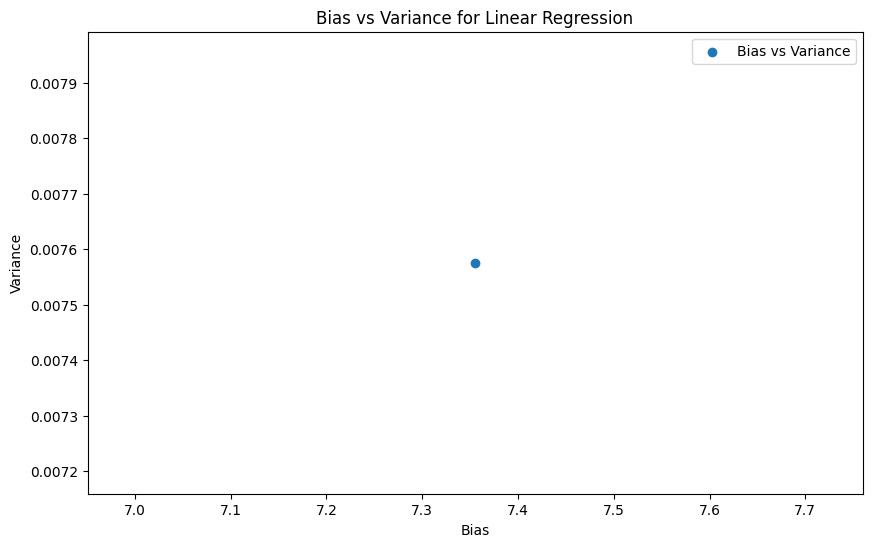

*** Bias-Variance Analysis for Ridge Regression ***
Mean Squared Error: 7.353443072309895
R-squared: 0.6133270950889878
Mean Squared Error: 7.3865687161775595
R-squared: 0.6155615532741807
Mean Squared Error: 7.315712637847776
R-squared: 0.6123499832422684
Mean Squared Error: 7.421653976919362
R-squared: 0.6142880523602929
Mean Squared Error: 7.3669852062047605
R-squared: 0.6117625315490318


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.12382e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.12321e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.12453e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.13646e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Average Expected Loss: 7.361414171431436
Average Bias: 7.354662843725522
Average Variance: 0.00675132770591301



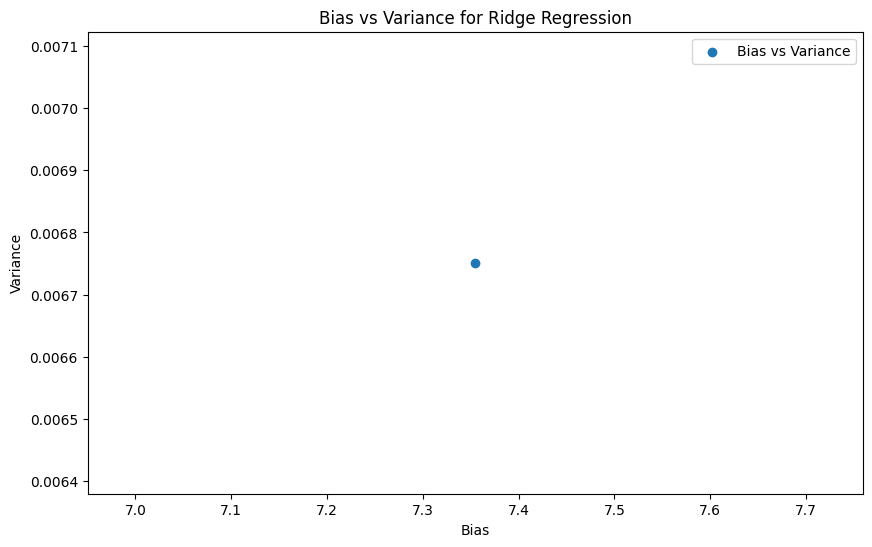

*** Bias-Variance Analysis for Random Forest ***
Mean Squared Error: 1.1939523092909503
R-squared: 0.9372173003559104
Mean Squared Error: 1.1819430301970864
R-squared: 0.9384850584748214


KeyboardInterrupt: ignored

In [17]:
from mlxtend.evaluate import bias_variance_decomp
from sklearn import preprocessing, model_selection, decomposition, metrics
import matplotlib.pyplot as plt

# Plotting and looking more at Bias & Variance for models

# Initialize models
models = {
    'Linear Regression': linear_model.LinearRegression(),
    'Ridge Regression': linear_model.Ridge(),
    'Random Forest': ensemble.RandomForestRegressor(),
    'Support Vector Machine': svm.SVR(),
    'Multi-Layer Perceptron': neural_network.MLPRegressor()
}

# Bias-variance analysis for each model
for model_name, model in models.items():
    print(f"*** Bias-Variance Analysis for {model_name} ***")

    # Train and evaluate the model
    mse_list, r2_list = model_train_and_eval(model, X, y, k_fold=True, standardization=True, model_name=model_name)

    # Convert the lists to NumPy arrays
    mse_array = np.array(mse_list)
    r2_array = np.array(r2_list)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

    # Use mlxtend's bias_variance_decomp with both training and testing sets
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        model, X_train.values, y_train.values, X_test.values, y_test.values, loss='mse', num_rounds=5, random_seed=42
    )

    print(f"Average Expected Loss: {avg_expected_loss}")
    print(f"Average Bias: {avg_bias}")
    print(f"Average Variance: {avg_var}\n")

    # Optionally, you can visualize the bias-variance trade-off
    plt.figure(figsize=(10, 6))
    plt.scatter(avg_bias, avg_var, label='Bias vs Variance', marker='o')
    plt.title(f'Bias vs Variance for {model_name}')
    plt.xlabel('Bias')
    plt.ylabel('Variance')
    plt.legend()
    plt.show()

